In [2]:
import mesa
import numpy as np
import random
import pandas as pd

In [3]:
def compute_consensus(model):
    agent_opinions = [agent.opinion for agent in model.schedule.agents]
    agreed_opinions = [i for i in agent_opinions if i >= 0.9]
    return len(agreed_opinions) / len(agent_opinions)

class Agent(mesa.Agent):
    
    def __init__(self, unique_id, model, w = 0.2, alpha = 0.1):
        super().__init__(unique_id, model)
        # Initialise each agent with an opinion on whether H1 is true. Randomly distributed between 0 and 1.
        self.opinion = random.uniform(0,1)
        # Weight is the same for each agent, since we are planning to use special case in SProdOp 
        self.weight = w
        self.alpha = alpha

        
    def pool_agents(self):
        # Want to return the self + n neighbouring agents.         
        neighbours = 0
        pooled_agents = [self]
        
        # Random approach - randomly choose n agents, assumes 'Well-mixed' model.
        while neighbours < self.model.pool_size:
            other_agent = self.random.choice(self.model.schedule.agents)
            
            if other_agent not in pooled_agents:
                pooled_agents.append(other_agent)
                neighbours += 1
        return pooled_agents
    
    def SProdOp(self, pooled_agents): 
        # SProdOp from combining opinion pooling paper. Only works in special case when w = const.
        pooled_opinions = []
        for agent in pooled_agents:
            pooled_opinions.append(agent.opinion)
        
        w = self.weight
        c_x = (np.prod(pooled_opinions)**w)/((np.prod(pooled_opinions)**w)+(np.prod(list(1-np.asarray(pooled_opinions)))**w))
        
        for agent in pooled_agents:
            agent.opinion = c_x
            
    def bayesian_update(self):
        # Bayesian update according to Definition 3.1 from combining opinion pooling paper
        alpha = self.alpha
        op_val1 = self.opinion
        op_val2 = 1 - self.opinion
        self.opinion = ((1-alpha) * op_val1) / ((alpha * op_val2) + (1 - alpha) * (1 - op_val2))        
        
    def step(self):
        pooled_agents = self.pool_agents()
        self.SProdOp(pooled_agents)
        # Simulate agents randomly coming comparing the two options
        x = random.uniform(0,1)
        if x < 0.5:
            self.bayesian_update()   
        
        
class Model(mesa.Model):
    
    def __init__(self, K, n):
        self.num_agents = K
        self.schedule = mesa.time.RandomActivation(self)
        self.pool_size = n
        self.running = True
        
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)
            
        self.datacollector = mesa.DataCollector(
            model_reporters = {"Consensus" : compute_consensus}, agent_reporters = {"Opinion" : "opinion"}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

<AxesSubplot:>

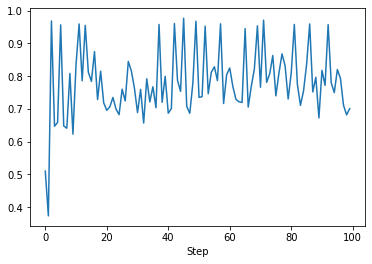

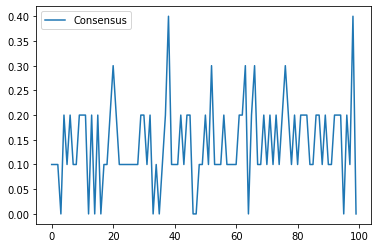

In [4]:
model = Model(10, n=3)
for i in range(100):
    model.step()
    
    
agent_opinion = model.datacollector.get_agent_vars_dataframe()
one_agent_opinion = agent_opinion.Opinion.xs(8, level = "AgentID")
one_agent_opinion.plot()


model_consensus = model.datacollector.get_model_vars_dataframe()
model_consensus.plot()

In [12]:
params = {"K": 10, "n": 3}

results = mesa.batch_run(
    Model,
    parameters=params,
    iterations=2,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

results_df = pd.DataFrame(results)

100%|█████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 26.57it/s]


<AxesSubplot:>

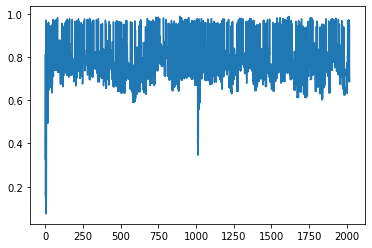

In [13]:
results_df['Opinion'].plot()

<AxesSubplot:>

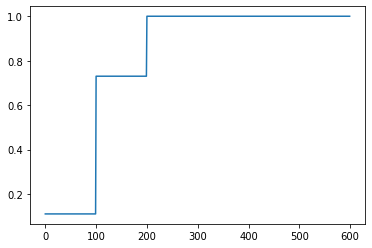

In [7]:
results_df["Consensus"].plot()